# Advanced Lane Finding Project #

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline

### Firstly, run camera calibration using chessboard images: ###

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        imgshape = (img.shape[0], img.shape[1])
        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgshape, None, None)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)


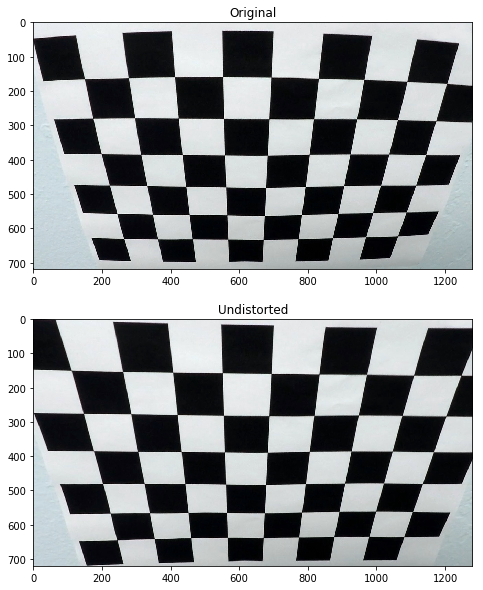

In [3]:
# output original and undistorted sample chessboard
ori_chessboard = cv2.imread('./camera_cal/calibration2.jpg')
undistored_chessboard = undistort(ori_chessboard)
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(ori_chessboard)
plt.title('Original')
plt.subplot(212)
plt.imshow(undistored_chessboard)
plt.title('Undistorted')

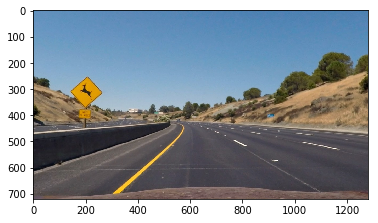

In [4]:
# output a sample for quick sanity check, we will use it to test the pipeline too.
sample_img = cv2.imread('./test_images/test2.jpg')
sample_undistorted = undistort(sample_img)
plt.imshow(cv2.cvtColor(sample_undistorted, cv2.COLOR_BGR2RGB))

### Then we define the thresholding functions ###

In [5]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_threshold(img, s_thresh=(90, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    #H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    return binary_output

# Use color transforms, gradients, etc., to create a thresholded binary image.
def thresholding(img):
    gradx = abs_sobel_thresh(img, 'x', 10, 230)
    grady = abs_sobel_thresh(img, 'y', 10, 230)
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 150))
    dir_binary = dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.3))
    hls_binary = hls_threshold(img, s_thresh=(90, 255))
    combined = np.zeros_like(hls_binary)
    combined[((gradx == 1) & (hls_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # combined[(hls_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

I tried multiple combination of thresholding, turns out the one montioned in the lecture sample code ```((gradx == 1) & (hls_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))``` 
is the most robust.

See the results on sample image below:

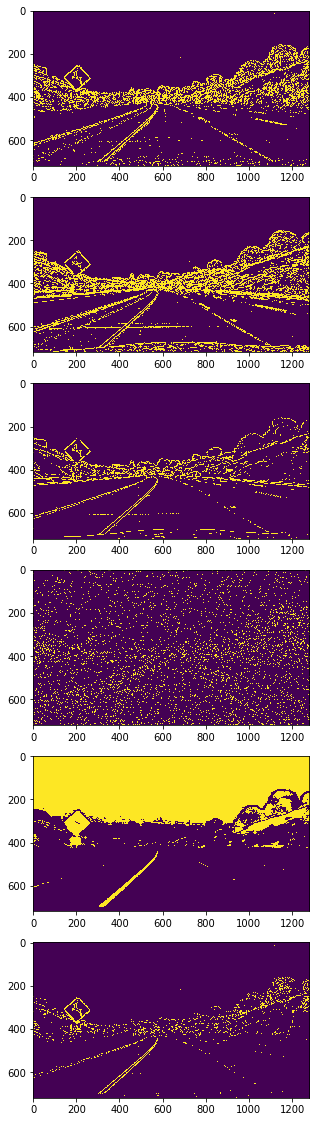

In [6]:
# check the results of different thresholding methods
abs_sobel_x_result = abs_sobel_thresh(sample_undistorted, 'x', 10, 230)
abs_sobel_y_result = abs_sobel_thresh(sample_undistorted, 'y', 10, 230)
mag_result = mag_thresh(sample_undistorted, sobel_kernel=3, mag_thresh=(30, 150))
dir_result = dir_threshold(sample_undistorted, sobel_kernel=3, thresh=(0.9, 1.1))
hls_result = hls_threshold(sample_undistorted, s_thresh=(90, 255))

sample_binary_thresholded = thresholding(sample_undistorted)

plt.figure(figsize=(20,20))
plt.subplot(611)
plt.imshow(abs_sobel_x_result)
plt.subplot(612)
plt.imshow(abs_sobel_y_result)
plt.subplot(613)
plt.imshow(mag_result)
plt.subplot(614)
plt.imshow(dir_result)
plt.subplot(615)
plt.imshow(hls_result)
plt.subplot(616)
plt.imshow(sample_binary_thresholded)


### Then the perspective transformation ###

Get the correct source region is a little tricky, I tried multiple times on the straight_lines image, to make sure the result lanes are parallel and vertical. (But please note the example below is not the straight line example.)

In [7]:
# perspective transform
def perspective_trans(img):
    far_x_offset = 95
    near_y_offset = 30
    near_x_offset = 4
    src = [[640 - far_x_offset, 460],
           [640 + far_x_offset, 460],
           [1280 - near_x_offset, 720 - near_y_offset],
           [near_x_offset, 720 - near_y_offset]]
    dst = [[0,0], [1280,0],[1280,720],[0,720]]
    M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
    Minv = cv2.getPerspectiveTransform(np.float32(dst), np.float32(src))
    warped = cv2.warpPerspective(img, M, dsize = (img.shape[1],img.shape[0]), flags = cv2.INTER_LINEAR)
    return warped, M, Minv


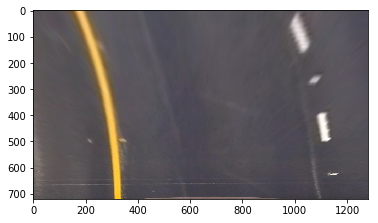

In [8]:
# show the transformation of original image
sample_warped, M, Minv = perspective_trans(sample_undistorted)
plt.imshow(cv2.cvtColor(sample_warped, cv2.COLOR_BGR2RGB))

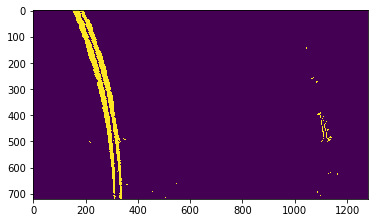

In [9]:
# show the tranformation of binary-thresholded image
sample_binary_warped = thresholding(sample_warped)
plt.imshow(sample_binary_warped)

### Then we can fit the lanes with polynomial ###

To avoid wiggle, we use "smoother" to keep the latest 5 valid frames and return the average

In [10]:
# To avoid wiggle, we use "smoother" to keep the latest 5 valid frames and return the average
class LineSmoother():
    def __init__(self):
        self.max_cnt = 5
        self.left_fits = []
        self.right_fits = []
    
    # we consider the result is valid if the curve radius are significantly different,
    # i.e., one side is more than double of the other.
    def is_sanity_checked(self, left_fit, right_fit, y = 720):
        left_curverad = ((1 + (2*left_fit[0]*y + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        diff = 1.0 * max(left_curverad, right_curverad) / min(left_curverad, right_curverad)
        return diff <= 2
    
    def add_new_lines(self, left_fit, right_fit):
        if not self.is_sanity_checked(left_fit, right_fit) and len(self.left_fits) > 0:
            return
        if len(self.left_fits) < self.max_cnt:
            self.left_fits.append(left_fit)
            self.right_fits.append(right_fit)
        else:
            self.left_fits = self.left_fits[1:]
            self.left_fits.append(left_fit)
            self.right_fits = self.right_fits[1:]
            self.right_fits.append(right_fit)
    
    def get_avg_lines(self):
        return (np.mean(self.left_fits, axis = 0), np.mean(self.right_fits, axis = 0))

In [11]:
# sliding window to fit polynomial

cur_left_fit = None
cur_right_fit = None

smoother = LineSmoother()

def fit_poly(binary_warped, plot = False, original = None):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)        
    
    # don't use smoother when debugging
    if not plot:
        smoother.add_new_lines(left_fit, right_fit)
        left_fit, right_fit = smoother.get_avg_lines()
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # plot=True when debugging 
    if plot:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

    left_lane_bottom = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_lane_bottom = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    distance_from_center = (1280 / 2 - (left_lane_bottom + right_lane_bottom) / 2) * xm_per_pix
    # print('position from center:', distance_from_center, 'm')
        
    return (left_fit, right_fit, (left_curverad + right_curverad) / 2, distance_from_center)


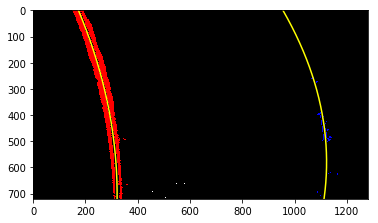

In [12]:
# run on the sample image
sample_left_fit, sample_right_fit, sample_curverad, sample_distance_from_center = fit_poly(sample_binary_warped, plot = True)

### Warp the detected lane boundaries back onto the original image: ###

In [13]:
# Warp the detected lane boundaries back onto the original image.
def warp_back(binary_warped, left_fit, right_fit, curverad, distance, Minv, original):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original.shape[1], original.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    
    # write the curve radius and distance info
    cv2.putText(result, 'Curve Radius: ' + str(curverad) + 'm', (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)
    cv2.putText(result, 'Distance from center: ' + str(distance) + 'm', (10,60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)
    return result

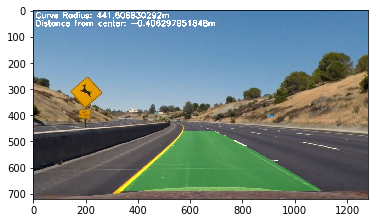

In [14]:
# run on the sample image
sample_result = warp_back(sample_binary_warped, sample_left_fit, sample_right_fit, 
                          sample_curverad, sample_distance_from_center, Minv, sample_undistorted)
plt.imshow(cv2.cvtColor(sample_result, cv2.COLOR_BGR2RGB))

### Here is the full pipeline: ###

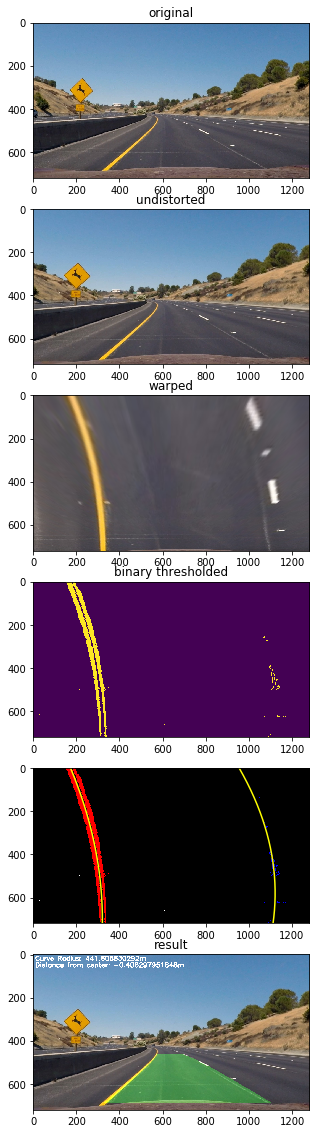

In [15]:
# full pipeline for a single image, plot = True for debugging
def pipeline(img, plot = False):
    if plot:
        plt.figure(figsize=(20, 20))
        plt.subplot(611)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('original')
    img = undistort(img)
    if plot:
        plt.subplot(612)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('undistorted')
    original_img = img
    warped, M, Minv = perspective_trans(img)
    if plot:
        plt.subplot(613)
        plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        plt.title('warped')
    binary_warped = thresholding(warped)
    if plot:
        plt.subplot(614)
        plt.imshow(binary_warped)
        plt.title('binary thresholded')
        plt.subplot(615)
    left_fit, right_fit, curverad, distance = fit_poly(binary_warped, plot, original_img)
    result = warp_back(binary_warped, left_fit, right_fit, curverad, distance, Minv, original_img)
    if plot:
        plt.subplot(616)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.title('result')
    return result

img = cv2.imread('./test_images/test2.jpg')
result = pipeline(img, True)


In [ ]:
# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile("./project_video_result.mp4", audio=False)
